# Web Speed Trends
<p style='font-size:1.2em'> Ethan Swan </p>

<br>

What is the meaning of life?
This deep question has occupied the minds of history's greatest thinkers.

While the last generation posited [42](https://www.independent.co.uk/life-style/history/42-the-answer-to-life-the-universe-and-everything-2205734.html) and considered the issue settled, I beg to differ.
I am a millenial, and as such, the only things that I believe to be important are avocado toast and wifi speeds.
Since data analysis on the former seems impractical, I recently put some time into answering a few questions about the latter using nothing but basic computer and statistics knowledge.

On a serious note, it is pretty remarkable how much our lives are affected by the internet but how little we know about its function.
While I wouldn't suggest that everyone needs to know the details of [TCP and UDP](https://www.cyberciti.biz/faq/key-differences-between-tcp-and-udp-protocols/), I do think that a practical understanding of the internet can really be useful in day-to-day life. And that practical understanding naturally starts with the questions:

**When is the internet fast and when is it slow? Is there a trend? Can I reschedule my voracious consumption of Game of Thrones so I don't have to wait for buffering?**

*or*

**Is internet speed always the same, at least for all practical purposes?**

And thus, to find the answers, I made the most of the various tech junk in my apartment.
I set up a Python script on a Raspberry Pi, and for three 7-day periods, that script measured the internet speed every hour and stored the output.
It's worth noting that these 7-day periods did *not* start at the same time each week, so this is not 21 contiguous days.
It's also worth noting that I did not alter my regular behavior during this time, so presumably the measurements are affected by my video streaming habits.
You might say that's fairly unscientific; I might say that I'm not giving up my consumption of the NBA for three weeks.

The following article has some code interspersed.
If you're interested, take a look.
If you're not, I promise that you won't miss out on anything by just skipping over it.

In [1]:
# Imports
import sqlite3
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
# Pull in the data
con = sqlite3.connect('data.db')
speeds = pd.read_sql('SELECT * FROM data', con)
speeds.columns = ['download', 'timestamp', 'upload', 'ping']

For context, the data looks like this:

In [2]:
speeds.head(10)

,download,timestamp,upload,ping
0,13083797.443421926,2018-02-12T00:06:34.206832Z,7760595.926517854,42.011
1,13360250.885051023,2018-02-12T00:07:32.157422Z,9432117.729862094,39.1
2,13565831.228703678,2018-02-12T00:08:31.845856Z,9392179.93813191,36.811
3,12628749.555523034,2018-02-12T00:11:09.122278Z,9302210.991833623,35.046
4,9144189.487892594,2018-02-12T01:11:09.431576Z,9434854.579579351,39.62
5,10269775.494369367,2018-02-12T02:11:09.500799Z,9297766.744410789,47.041
6,9652531.079817662,2018-02-12T03:11:09.884584Z,9262163.345497014,38.163
7,14397477.266235093,2018-02-12T04:11:09.790934Z,9481690.481398284,39.619
8,13271494.868615385,2018-02-12T05:11:08.856195Z,9178280.21452893,38.207
9,14710803.021194931,2018-02-12T06:11:09.310271Z,9538493.232564144,42.392


That's download and upload speed in bits per second, a timestamp, and a "ping" latency time.

### Speed and Latency

Let's talk about the difference between speed and latency.

Speed is a measure of how much information can travel during one second. It also scales linearly: if you can send *x* bits in 3 seconds, you can send *2x* bits in 6 seconds. Speed is like the **width** of a pipe - wider pipes allow more liquid to flow at one time.

Latency, on the other hand, is like a delay.
That's what the ping column represents.
Latency is the lag for information to travel between you and the server. It's not linear -- it's basically a one-time cost in each "request" you make.
In the metaphor of a pipe, latency is the **length**.
Liquid will take a while to get from one side of the pipe to the other, but once it starts flowing you don't notice anymore because more liquid is already coming down the pipe, backfilling it.

### This is all fine and good, but what does it mean in the context of the internet?

If you're streaming Netflix, it only takes one request to tell Netflix that you want to see episode 1 of New Girl. This request has *latency*, but it only has to happen once.
Then the show is sent to your device at the *download speed*. It's consistently taking a small amount of time (latency) to get from the servers to you, but you don't notice because by the time you're received the first 10 seconds, Netflix has already sent the next 10 seconds and you receive it without experiencing more lag. From your perspective, the show is just playing at regular speed.

On the other hand, if you're interacting with the web a lot -- maybe clicking through Wikipedia pages -- you're going to notice latency, because each time you request a new page, that latency is incurred.
While Netflix knew that you were going to want the next 10 seconds of the show after you watched the first 10 seconds, Wikipedia has no idea what page you want to see next and thus can't send it to you until you click.
At that point, you experience the latency.

Obviously, the above description is very simplistic.
But to continue being reductionist, most tasks that are constrained by internet speeds are bottlenecked by download speeds (e.g. streaming) and occasionally by upload speeds (e.g. sending an email with a large attachment).
For this reason, the following analysis will focus on download and upload speed, but exclude latency.

Let's start by looking at download and upload speed over the three weeks. There will be gaps in here, along with a lot of "noise" in the data created by random events, so we can't infer too much yet. But it's a good starting point.

In [3]:
# Convert from bits/second to megabits/second.
speeds['timestamp'] = pd.to_datetime(speeds['timestamp'])
for colname in ['upload', 'download']:
    speeds[colname] = speeds[colname].astype(np.float) / 1000000
# Correct timezones.
speeds['timestamp'] = speeds['timestamp'] - pd.Timedelta(hours=5)

In [4]:
# Melt the data for plotting
melted = speeds.melt(id_vars=['timestamp'])
melted.columns = ['timestamp', 'measure', 'value']
melted['value'] = melted['value'].astype(np.float)

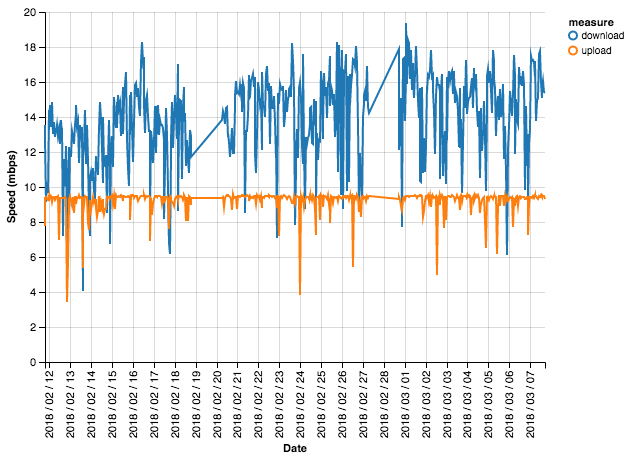

In [5]:
# Keep only upload and download measurements
up_down_speeds = melted.query('measure in ["download", "upload"]')
# Plot
alt.Chart(up_down_speeds).mark_line().encode(
    x=alt.X('timestamp',
            axis=alt.Axis(title='Date',
                          format='%Y / %m / %d',
                          ticks=24)),
    y=alt.Y('value',
            axis=alt.Axis(title='Speed (mbps)')),
    color='measure')

This data is indeed very noisy -- we see huge fluctuations, so much so that it's hard to make out a pattern. But we can learn a few things: download speed is almost always larger than upload speed, and download speed also looks to bounce around more dramatically than upload speed. This *bouncing around* quality is called variance, so we would say that download speed has high variance.

Let's view that difference in variance in a different way.
We'll use histograms and density plots.
If you're not familiar with these visuals, they show how data is spread throughout a range.
Let's take a look.

/Users/eswan18/anaconda3/envs/ad_hoc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


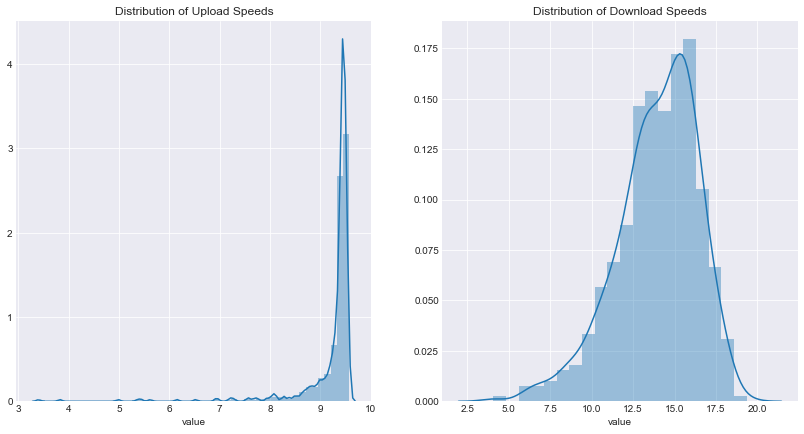

In [6]:
# Set the figure size larger.
figsize(14, 7)
# Create figure and side-by-side axes
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Draw two distplots, one for upload and one for download
up_speeds = up_down_speeds.query('measure == "upload"')
down_speeds = up_down_speeds.query('measure == "download"')
g1 = sns.distplot(up_speeds['value'], ax=ax1)
g2 = sns.distplot(down_speeds['value'], ax=ax2)
g1.set_title('Distribution of Upload Speeds')
g2.set_title('Distribution of Download Speeds');

We see in the left plot that the vast majority of upload speeds are between 9 and about 9.75 megabits per second, thus the peak between 9 and 10 on the x-axis.
Meanwhile, the right plot shows that download speed is much more spread out. It looks like it generally falls between 10 and 20 megabits per second.

The bell-shaped curve in the right plot is typical of something called a *normal distribution*, a foundational concept in statistics.
While we won't dive deeply into its practical significance, normal distribution occurs in all kinds of situations.
Finding that our data is normally distributed should give us some confidence that we haven't made any silly mistakes in data collection.

## Is web speed meaningfully different by day of week? By hour?

While what we found above was interesting (okay, to me at least), it isn't particularly actionable.
On the other hand, knowing when internet speeds are fastest really is worthwhile.

Earlier, we saw a lot of noise in our data. Luckily, by aggregating it, we can remove much of that distraction and distill the "real" pattern better.
First, speeds by day of week:

In [7]:
# Make a copy of the data for this bit.
time_speeds = up_down_speeds.copy()
# Extract pieces of the timestamp
time_speeds['weekday'] = time_speeds['timestamp'].dt.weekday_name
time_speeds['hour'] = time_speeds['timestamp'].dt.hour
time_speeds['minute'] = time_speeds['timestamp'].dt.minute
time_speeds = time_speeds.drop('timestamp', axis=1)

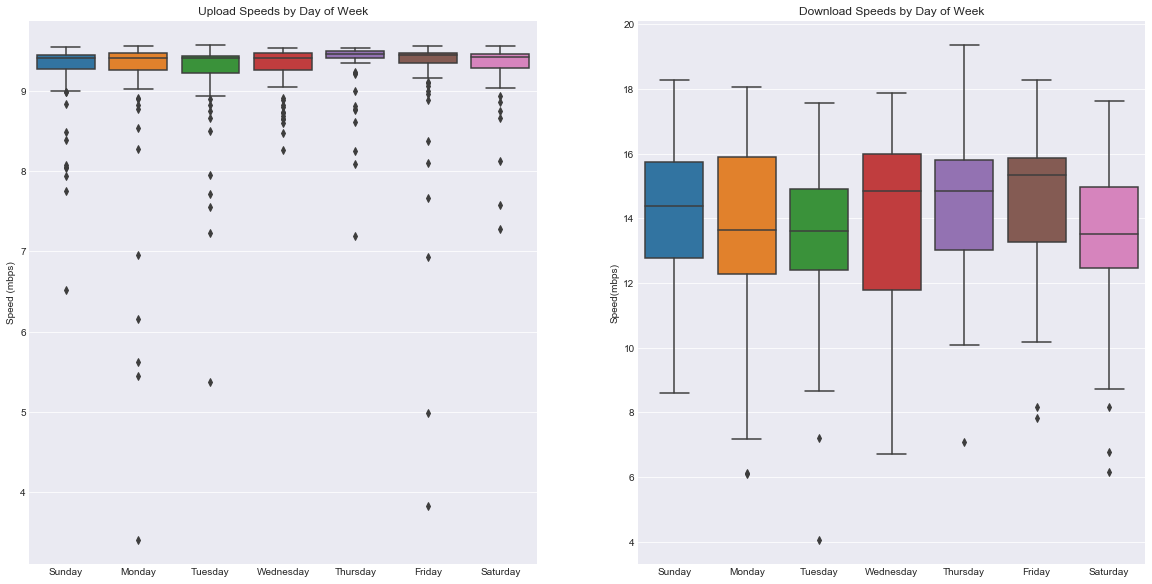

In [8]:
up_time_speeds = time_speeds.query('measure == "upload"')
down_time_speeds = time_speeds.query('measure == "download"')

fig, ax = plt.subplots(ncols=2, figsize=(20, 10), sharey=False)
g = sns.boxplot('weekday', 'value', data=up_time_speeds, ax=ax[0])
g.set(title='Upload Speeds by Day of Week', xlabel='', ylabel='Speed (mbps)')
g2 = sns.boxplot('weekday', 'value', data=down_time_speeds, ax=ax[1])
g2.set(title='Download Speeds by Day of Week', xlabel='', ylabel='Speed(mbps)');

*n.b. The y-axis values are not the same.*

We're using boxplots here.
Boxplots convey a lot of information: the line in the middle of each box is the *median*, and the top and bottom lines defining the box are the *first and third quartiles*.
The narrow lines that extend beyond the boxes cover the full *range* of the data, excluding outliers.

If this doesn't mean anything to you, don't worry; just think of the boxes as defining the range of speeds that are typical during a certain day.
Or, if you'd like to learn a little more about boxplots, check out [this](https://flowingdata.com/2008/02/15/how-to-read-and-use-a-box-and-whisker-plot/) explanation.

For all that effort, it looks like speeds by day are largely the same.
Upload speeds barely change at all -- even with a smaller y-axis, the speeds are tightly clustered together.
There are certainly some differences in download speeds, but nothing large enough to be sure we're not just seeing randomness.

Let's take a look at speed by hour.

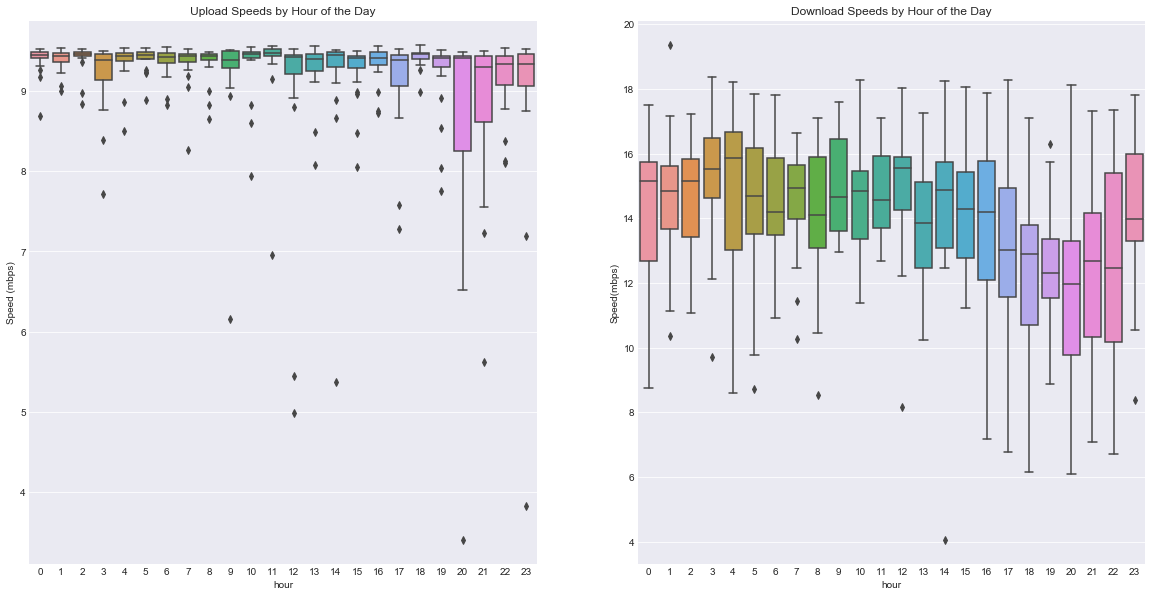

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10), sharey=False)
g = sns.boxplot('hour', 'value', data=up_time_speeds, ax=ax[0])
g.set(title='Upload Speeds by Hour of the Day', ylabel='Speed (mbps)')
g2 = sns.boxplot('hour', 'value', data=down_time_speeds, ax=ax[1])
g2.set(title='Download Speeds by Hour of the Day', ylabel='Speed(mbps)');

Ah, a pattern!
Download speeds show a discernable trend. Speeds bounce around during the early morning until evening, when they rapidly drop.
Around 10pm, they rebound.
This makes a lot of sense!
All those selfish people sitting on their couches, streaming Netflix, slowing down our internet...

Oh wait, that's what I do.

What happens if we look at both day and hour simultaneously? We'll do it for download only, since upload seems not to vary much.

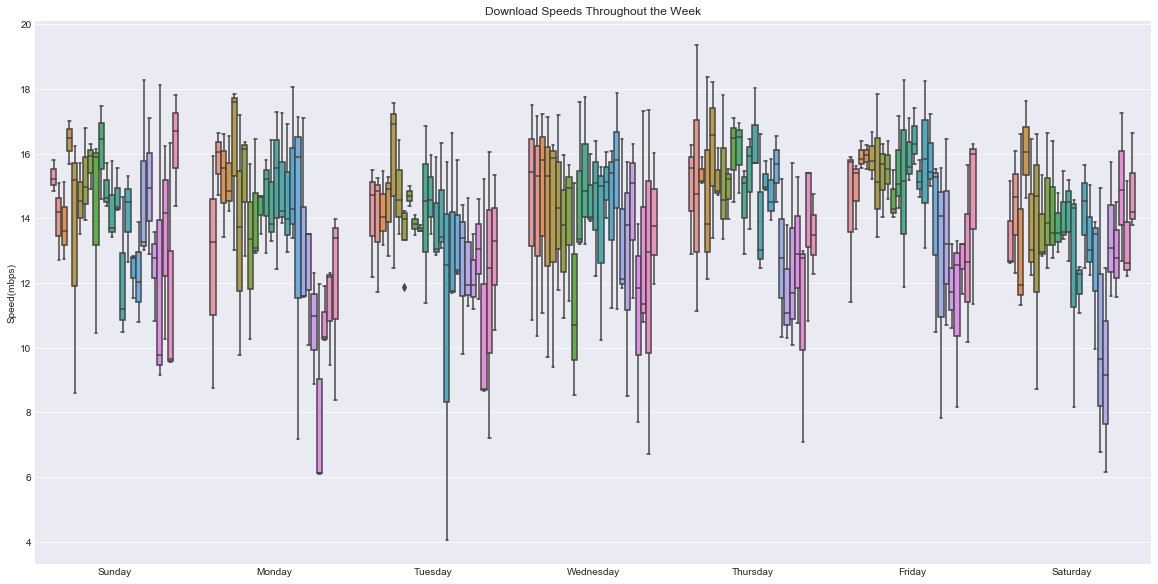

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(20, 10))
g = sns.boxplot(x='weekday', y='value', hue='hour', data=down_time_speeds, ax=ax)
g.set(title='Download Speeds Throughout the Week', xlabel='', ylabel='Speed(mbps)')
ax.legend().set_visible(False)

Whoa! There's a lot going on here. Luckily our newfound expertise in boxplots can help us digest this.

Each day looks to have a slightly different pattern, but in general it looks like speeds are highest early in the day (each day's data is arranged midnight-to-midnight).
However, at this point I think boxplots are actually making it harder to see trends.
Instead, let's simply view a graph of the mean speed throughout this time.

In [11]:
# Extract just hour and weekday from our data.
hours = down_speeds['timestamp'].dt.hour
weekdays = down_speeds['timestamp'].dt.weekday
# Construct a timestamp from just this information, starting arbitrarily at Jan 1 2018.
timestamps = ['1/%d/2018 %d:00'%(weekday+1, hour) for (weekday, hour) in zip(weekdays, hours)]
# Overwrite the old timestamp column with this new timestamp info.
mod_down_speeds = down_speeds.copy()
mod_down_speeds['timestamp'] = [pd.to_datetime(x) for x in timestamps]

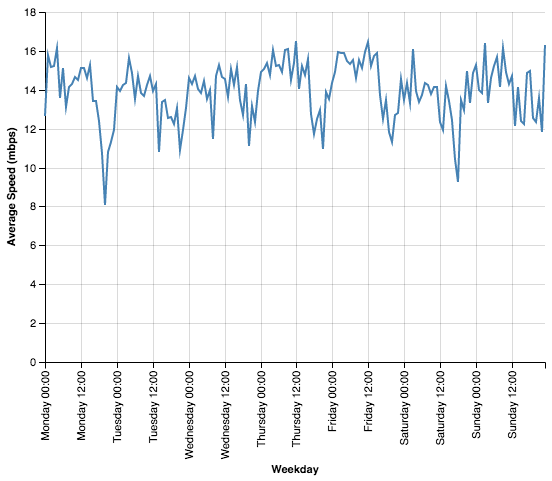

In [12]:
alt.Chart(mod_down_speeds).mark_line().encode(
    x=alt.X('timestamp:T',
            axis=alt.Axis(title='Weekday',
                          format='%A %H:00',
                          ticks=14)),
    y=alt.Y('average(value)', title='Average Speed (mbps)')
)

Okay, this a good start, but it looks pretty noisy.
Let's plot a moving average to smooth it out.
If you're not familiar with moving averages, they're a way of smoothing data by averaging each point with a few of the points on either side of it.
This results in a graph that shows similar trends but without as much fluctuation.

In [13]:
# First do the groupby and aggreation in mod_down_speeds
roll_down_speeds = mod_down_speeds.groupby('timestamp').mean()[['value']]
roll_down_speeds['timestamp'] = roll_down_speeds.index
# Then create a rolling average column
roll_down_speeds['mvg_value'] = roll_down_speeds['value'].rolling(window=5, center=True, min_periods=1).mean()

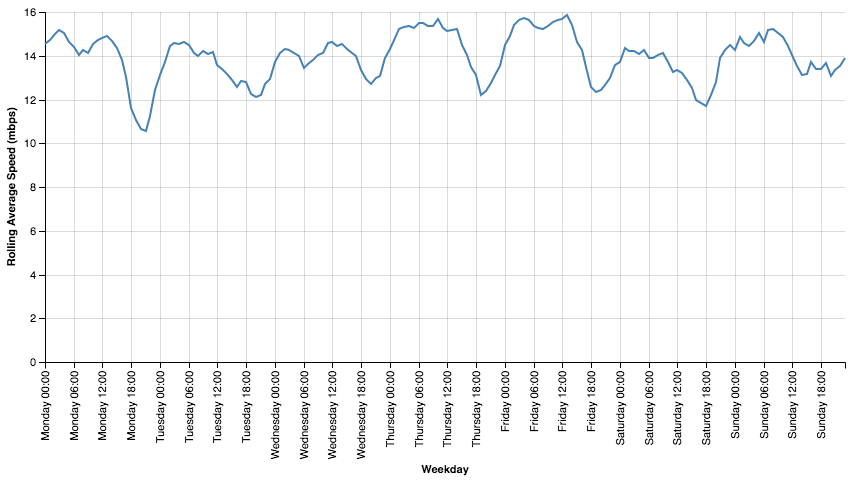

In [14]:
alt.Chart(roll_down_speeds).mark_line().encode(
    x=alt.X('timestamp:T',
            axis=alt.Axis(title='Weekday',
                          format='%A %H:00',
                          ticks=28)),
    y=alt.Y('mvg_value', title='Rolling Average Speed (mbps)')
).configure_cell(width=800)

This looks really helpful.
We have a clearer picture of the trend that started to appear earlier.
We consistently see a daily minimum at about 6-9pm, but the speed at that time is very different by weekday.
Tuesday and Wednesday show relatively little fluctuation throughout the day, but the drop in speed on Mondays from noon to evening is precipitous.
And Sundays have relatively good speeds all day, but the very fastest internet speeds are Thursday and Friday mornings.

### So what can we take from this?

If you've made it here, I suppose it's probably too late for a tldr. Still, let's review what we found:
- Download speeds are anywhere between one and two times as fast as upload speeds.
- Upload speeds hardly vary at all throughout the week.
- Download speeds vary an enormous amount during the week.
- Download speed variance shows distinct patterns; generally mornings bring fast downloads, but 6-9pm is consistently the worst time to be downloading content.

All in all, bad news for evening Netflixers. The worst time to be streaming is at night -- big surprise!
But while you might not be able to escape the weekday run on video content, it might be worth rearranging your weekends; even Saturday and Sunday have better internet speeds earlier in the day.
Binge in the mornings! It's better than hitting the gym anyway.

If you have ideas for further analysis of practical data, I would love to hear them. Find me on Twitter at @eswan18, or email me at eswan@alumni.nd.edu.